## Importing Packages

In [2]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from pathlib import Path
from collections import defaultdict
from collections import Counter
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay



## Loading the data

In [3]:
main_folder_path = 'Data'


class_labels = os.listdir(main_folder_path)
print(f"Class Labels: {class_labels}")

Class Labels: ['Benign', 'Early', 'Pre', 'Pro']


In [4]:
image_paths = []
labels = []

# get the image paths and labels
for label in class_labels:
    folder_path = os.path.join(main_folder_path, label)
    for image_file in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_file)
        image_paths.append(image_path)
        labels.append(label)

class_counts = Counter(labels)


## Plotting Class distributions

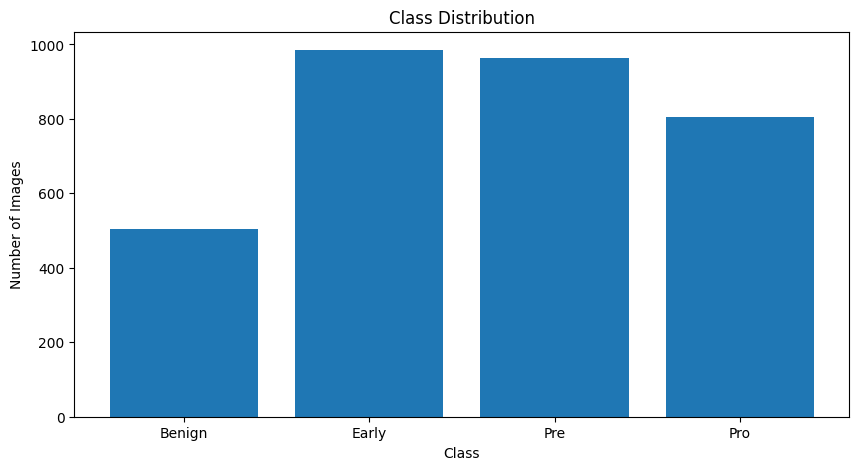

In [5]:
# plot the distribution of classes
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

## Displaying sample images from each class

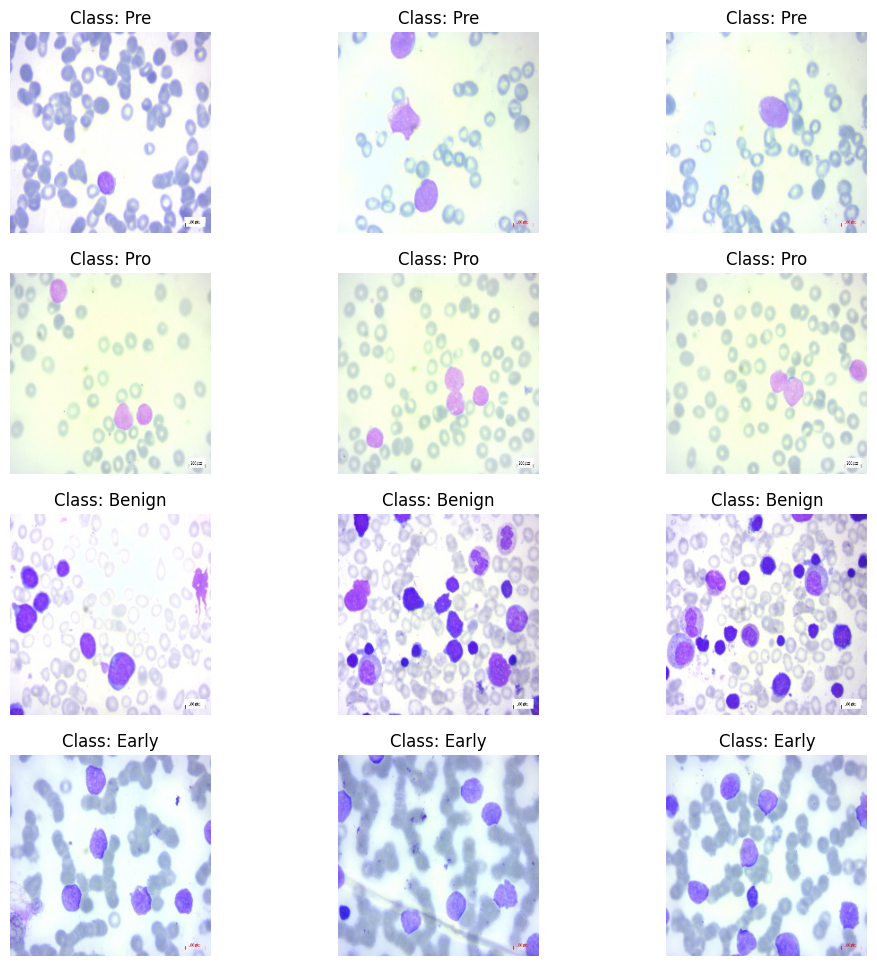

In [6]:
unique_labels = set(labels)
num_samples = 3
plt.figure(figsize=(12, 12))
for idx, label in enumerate(unique_labels):
    label_paths = [path for path, lbl in zip(image_paths, labels) if lbl == label]
    for i in range(num_samples):
        img = Image.open(label_paths[i])
        plt.subplot(len(unique_labels), num_samples, idx * num_samples + i + 1)
        plt.imshow(img)
        plt.title(f"Class: {label}")
        plt.axis('off')
plt.show()

## Check Image shapes

In [7]:
shapes = []
for img_path in image_paths:
    with Image.open(img_path) as img:
        shapes.append(img.size)

print(f"Unique image shapes: {set(shapes)}")


Unique image shapes: {(224, 224)}


## Calculate Statistics

In [8]:
image_arrays = []
for img_path in image_paths:
    with Image.open(img_path) as img:
        img = img.resize((224, 224))  # not necessary
        image_arrays.append(np.array(img))
    
all_images = np.stack(image_arrays)
mean_pixel = np.mean(all_images)
std_pixel = np.std(all_images)
    
print(f"Mean pixel value: {mean_pixel}")
print(f"Standard deviation of pixel values: {std_pixel}")

Mean pixel value: 222.49865009156304
Standard deviation of pixel values: 35.28683737951463


## Data Augmentation for the minority classes

We are going to apply multiple types of augmentations : 

**Rotation** : This augmentation randomly rotates images within a specified range. For example, with a range of 20 degrees, images can be rotated by any angle up to ±20 degrees.

**Width Shifting**: Width shifting translates images horizontally by a fraction of the image width. A range of 0.2 means that images can shift left or right by up to 20% of their width.

**Height Shifting**: Height shifting translates images vertically by a fraction of the image height. A range of 0.2 means images can move up or down by up to 20% of their height.

**Shear**: Shearing distorts the image along one axis, making it look as though parts of the image have been "pushed" or "pulled." This changes the shape of objects in the image, making them appear slanted. A range of 0.2 means the image can be sheared up to a factor of 0.2.

**Zoom**: Zooming in or out changes the scale of the image. A range of 0.2 means that the image can be zoomed in or out by up to 20%.

**Horizontal Flip**: This randomly flips images horizontally. This means that objects in the image will appear as mirror images.

**Fill Mode**: When an image is transformed (e.g., rotated, shifted), there can be "empty" areas created at the borders. The fill mode determines how these empty areas are filled. The nearest mode fills these areas with the nearest pixel values.

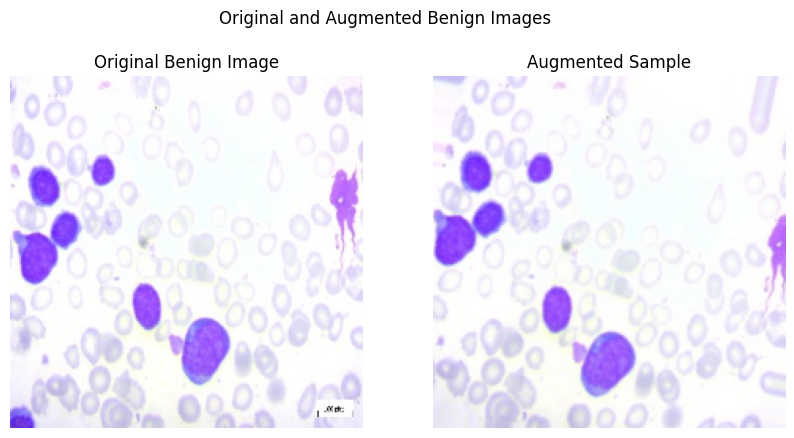

In [9]:

target_count = 950

benign_images = [img for img, label in zip(image_arrays, labels) if label == 'Benign']
current_count = len(benign_images)
num_new_images = target_count - current_count  

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

augmented_benign_images = []
benign_labels = ['Benign'] * num_new_images  

# augment each benign image until reaching the target count
for img in benign_images:
    img = img.reshape((1,) + img.shape)  
    for batch in datagen.flow(img, batch_size=1):
        augmented_benign_images.append(batch[0].astype(np.uint8))  
        if len(augmented_benign_images) >= num_new_images: 
            break
    if len(augmented_benign_images) >= num_new_images:
        break




target_count = 950

pro_images = [img for img, label in zip(image_arrays, labels) if label == 'Pro']
current_count = len(pro_images)
num_new_images = target_count - current_count  
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

augmented_pro_images = []
pro_labels = ['Pro'] * num_new_images  

# Augment each benign image until we reach the target count
for img in pro_images:
    img = img.reshape((1,) + img.shape)  
    for batch in datagen.flow(img, batch_size=1):
        augmented_pro_images.append(batch[0].astype(np.uint8))  
        if len(augmented_pro_images) >= num_new_images:  # Stop once we reach the required number
            break
    if len(augmented_pro_images) >= num_new_images:
        break


# display original and augmented sample
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(benign_images[0].astype(np.uint8))  # Show the first original image
plt.title("Original Benign Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(augmented_benign_images[0].astype(np.uint8))  # Show the first augmented image
plt.title("Augmented Sample")
plt.axis('off')

plt.suptitle("Original and Augmented Benign Images")
plt.show()

In [10]:
image_arrays.extend(augmented_benign_images)  
labels.extend(benign_labels)

image_arrays.extend(augmented_pro_images)  
labels.extend(pro_labels)

class_distribution = Counter(labels)
print("Updated Class Distribution:", class_distribution)

Updated Class Distribution: Counter({'Early': 985, 'Pre': 963, 'Benign': 950, 'Pro': 950})


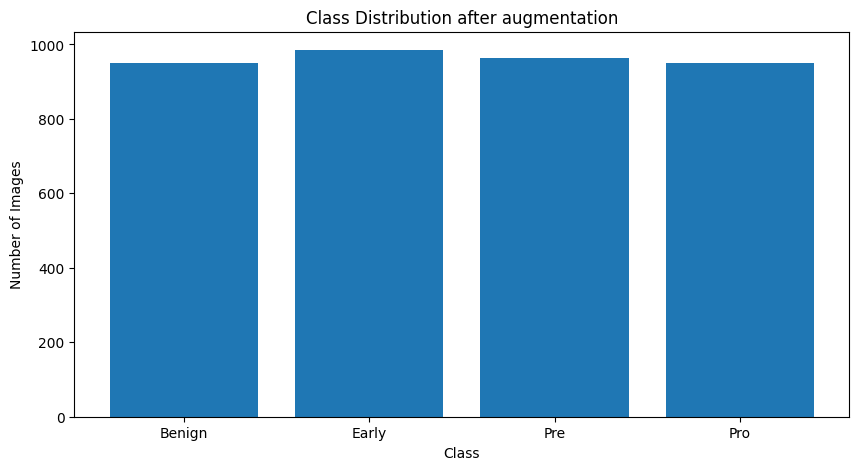

In [11]:
# Plot the new distribution of classes
plt.figure(figsize=(10, 5))
plt.bar(class_distribution.keys(), class_distribution.values())
plt.title('Class Distribution after augmentation')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

In [12]:
main_output_folder = 'Augmented_Dataset'
class_labels = ['Benign', 'Early', 'Pre', 'Pro']

# create directories
for label in class_labels:
    Path(os.path.join(main_output_folder, label)).mkdir(parents=True, exist_ok=True)

class_counters = defaultdict(int)

# save original and augmented images
for img_array, label in zip(image_arrays, labels):
    img = Image.fromarray(img_array)
    class_counters[label] += 1 
    img_name = f"{label}_{class_counters[label]:04d}.jpg"  
    img_path = os.path.join(main_output_folder, label, img_name)
    img.save(img_path)

## Encoding labels : one-hot encoding

In [13]:
class_names = list(set(labels))  
label_to_index = {label: index for index, label in enumerate(class_names)}
labels_encoded = [label_to_index[label] for label in labels]
labels_categorical = to_categorical(labels_encoded, num_classes=len(class_names))



## Split Data into train and validation set 

In [14]:
X_train, X_temp, y_train, y_temp = train_test_split(np.array(image_arrays), np.array(labels_categorical), test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## Pixel Normalization

In [15]:
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

## VGG19 Model

In [16]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [17]:
# freeze the layers of the base model to keep the pre-trained weights
for layer in base_model.layers:
    layer.trainable = False

In [18]:
# add custom classification layers on top of VGG19
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(class_names), activation='softmax')(x)

In [19]:
# final Model
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [22]:
checkpoint = ModelCheckpoint(
    'best_model.h5',            
    monitor='val_accuracy',      
    verbose=1,                   
    save_best_only=True,         
    mode='max'                   
)


history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint]       
)

Epoch 1/30
85/85 [==============================] - ETA: 0s - loss: 0.4687 - accuracy: 0.8303
Epoch 1: val_accuracy improved from -inf to 0.93934, saving model to best_model.h5
85/85 [==============================] - 443s 5s/step - loss: 0.4687 - accuracy: 0.8303 - val_loss: 0.2067 - val_accuracy: 0.9393
Epoch 2/30


C:\Users\User\Desktop\ProjetML\Codes\venv\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - ETA: 0s - loss: 0.2827 - accuracy: 0.8923
Epoch 2: val_accuracy improved from 0.93934 to 0.94627, saving model to best_model.h5
85/85 [==============================] - 452s 5s/step - loss: 0.2827 - accuracy: 0.8923 - val_loss: 0.1489 - val_accuracy: 0.9463
Epoch 3/30
85/85 [==============================] - ETA: 0s - loss: 0.2116 - accuracy: 0.9172
Epoch 3: val_accuracy improved from 0.94627 to 0.96014, saving model to best_model.h5
85/85 [==============================] - 453s 5s/step - loss: 0.2116 - accuracy: 0.9172 - val_loss: 0.1221 - val_accuracy: 0.9601
Epoch 4/30
85/85 [==============================] - ETA: 0s - loss: 0.1662 - accuracy: 0.9358
Epoch 4: val_accuracy did not improve from 0.96014
85/85 [==============================] - 436s 5s/step - loss: 0.1662 - accuracy: 0.9358 - val_loss: 0.1350 - val_accuracy: 0.9567
Epoch 5/30
85/85 [==============================] - ETA: 0s - loss: 0.1448 - accuracy: 0.9436
Epoch 5: val_accuracy 

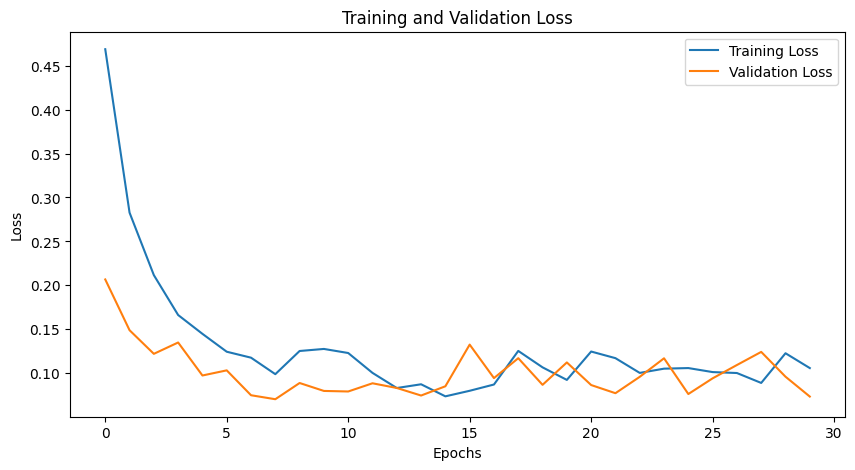

In [23]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)


report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("Classification Report:\n", report)

19/19 [==============================] - 71s 4s/step
Classification Report:
               precision    recall  f1-score   support

         Pre       0.99      0.98      0.99       154
         Pro       0.98      1.00      0.99       123
      Benign       0.93      0.99      0.96       137
       Early       0.98      0.93      0.96       164

    accuracy                           0.97       578
   macro avg       0.97      0.97      0.97       578
weighted avg       0.97      0.97      0.97       578



In [25]:
best_model = load_model('best_model.h5')


In [27]:
# evaluate the model on validation set
val_loss, val_accuracy = best_model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

19/19 [==============================] - 70s 4s/step - loss: 0.0851 - accuracy: 0.9827
Validation Accuracy: 98.27%


In [28]:
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)


report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("Classification Report:\n", report)

19/19 [==============================] - 70s 4s/step
Classification Report:
               precision    recall  f1-score   support

         Pre       0.99      0.99      0.99       154
         Pro       0.98      1.00      0.99       123
      Benign       0.95      0.96      0.96       137
       Early       0.97      0.95      0.96       164

    accuracy                           0.97       578
   macro avg       0.97      0.98      0.97       578
weighted avg       0.97      0.97      0.97       578



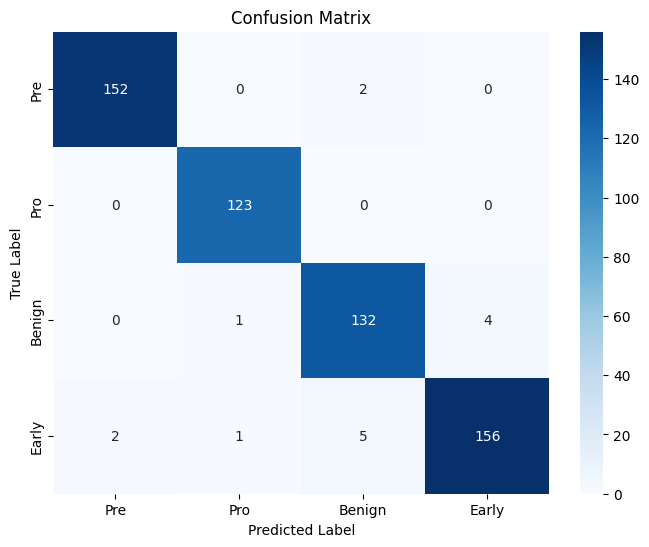

In [29]:
conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()